In [2]:
import pandas as pd
from pandas_indexing import isin, concat
import pandas_indexing.accessors
from dominate.tags import div
from dominate import document
from concordia import embed_image, add_sticky_toc
from concordia.report import HEADING_TAGS
from concordia.utils import RegionMapping
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from subprocess import run
from joblib import Parallel, delayed

In [3]:
version = "2023-08-07"

In [27]:
base_path = Path(
    "/Users/coroa/Library/CloudStorage/OneDrive-SharedLibraries-IIASA/RESCUE - WP 1/data"
)
out_path = base_path.parent / "analysis" / "harmonization"

In [5]:
regionmapping = RegionMapping.from_regiondef(
    base_path / "iam_files/rescue/regionmappingH12.csv",
    country_column="CountryCode",
    region_column="RegionCode",
    sep=";",
)

In [6]:
data = pd.read_csv(f"harmonization-{version}.csv", index_col=list(range(5))).rename(
    columns=int
)
model = data.pix.extract(
    variable="Emissions|{gas}|{sector}|Unharmonized", drop=True
).dropna(how="all", axis=1)
harm = data.pix.extract(
    variable="Emissions|{gas}|{sector}|Harmonized|{method}", drop=True
).dropna(how="all", axis=1)
hist = (
    data.loc[isin(model="Historic")]
    .pix.extract(variable="Emissions|{gas}|{sector}", drop=True)
    .dropna(how="all", axis=1)
    .pix.dropna(subset="region")
)

In [7]:
def extract_sector_gas(df):
    return concat(
        [
            df.pix.extract(
                variable="CEDS+|9+ Sectors|Emissions|{gas}|{sector}|Unharmonized",
                drop=True,
            ),
            df.pix.extract(
                variable="CEDS+|9+ Sectors|Emissions|{gas}|Unharmonized", drop=True
            ).pix.assign(sector="Total"),
        ]
    )

In [8]:
def make_totals(df):
    original_levels = df.index.names
    if 'method' in original_levels: # need to process harm
        df = df.droplevel('method')
    level = df.index.names
    ret = pd.concat([
        (
            df
            .loc[~isin(region='World')] # don't count aviation
            .groupby(level=list(set(level) - set(['region'])))
            .agg(lambda s: s.sum(skipna=False))
            .pix.assign(region="World", order=level)
        ), 
        (
            df
            .loc[~isin(sector="Total")] # don't count global totals
            .groupby(level=list(set(level) - set(['region', 'sector'])))
            .agg(lambda s: s.sum(skipna=False))
            .pix.assign(region='World', sector='Total', order=level)
        )
    ])
    if 'method' in original_levels: # need to process harm
        ret = ret.pix.assign(method="aggregate", order=original_levels)
    return ret

harm = concat([harm, make_totals(harm)])
model = concat([model, make_totals(model)])
hist = concat([hist, make_totals(hist)])

In [9]:
cmip6_hist = regionmapping.aggregate(
    pd.read_csv(
        base_path / "historical" / "cmip6" / "history.csv", index_col=list(range(5))
    )
    .rename_axis(index=str.lower)
    .rename(columns=int)
    .pipe(extract_sector_gas)
    .pix.assign(
        model="CEDS",
        scenario="CMIP6",
    ),
    level="region",
).pix.fixna().pix.dropna().loc[~isin(sector="Total")]

In [10]:
hist = concat([hist, cmip6_hist])

In [14]:
def plot_harm(sel, scenario=None, levels=["gas", "sector", "region"]):
    model_sel = sel if scenario is None else sel & isin(scenario=scenario)
    h = harm.loc[model_sel]
    data = concat(
        dict(
            CEDS=hist.loc[sel & isin(scenario="Synthetic (GFED/CEDS/Global)")],
            CMIP6=hist.loc[sel & isin(scenario="CMIP6")],
            Unharmonized=model.loc[model_sel],
            Harmonized=h.droplevel("method"),
        ),
        keys="key",
    ).loc[:, 2000:]

    non_uniques = [lvl for lvl in levels if len(h.pix.unique(lvl)) > 1]
    if not non_uniques:
        method = h.pix.unique("method").item()
        return data.T.plot(
            ylabel=data.pix.unique("unit").item(),
            title=" - ".join(data.pix.unique(["gas", "sector", "region"]).item())
            + f": {method}",
            legend=False,
        )

    (non_unique,) = non_uniques
    g = sns.relplot(
        data.rename_axis(columns="year").stack().to_frame("value").reset_index(),
        kind="line",
        x="year",
        y="value",
        col=non_unique,
        col_wrap=4,
        hue="key",
        facet_kws=dict(sharey=False),
        legend=False,
        height=2,
        aspect=1.5
    ).set(ylabel=data.pix.unique("unit").item())
    methods = pd.Series(h.index.pix.project("method"), h.index.pix.project(non_unique))
    for label, ax in g.axes_dict.items():
        ax.set_title(f"{non_unique} = {label}, method = {methods[label]}", fontsize=9)
    return g

<Axes: title={'center': 'CO2 - Total - World: aggregate'}, ylabel='Mt CO2/yr'>

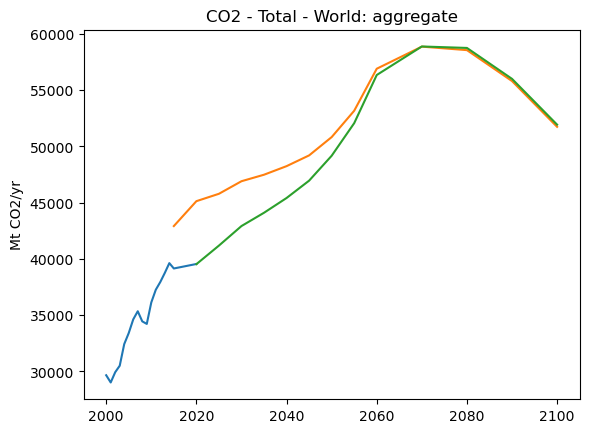

In [16]:
plot_harm(
    isin(region="World", sector="Total", gas="CO2"),
    scenario="RESCUE-Tier1-Extension-2023-07-27-Baseline",
)

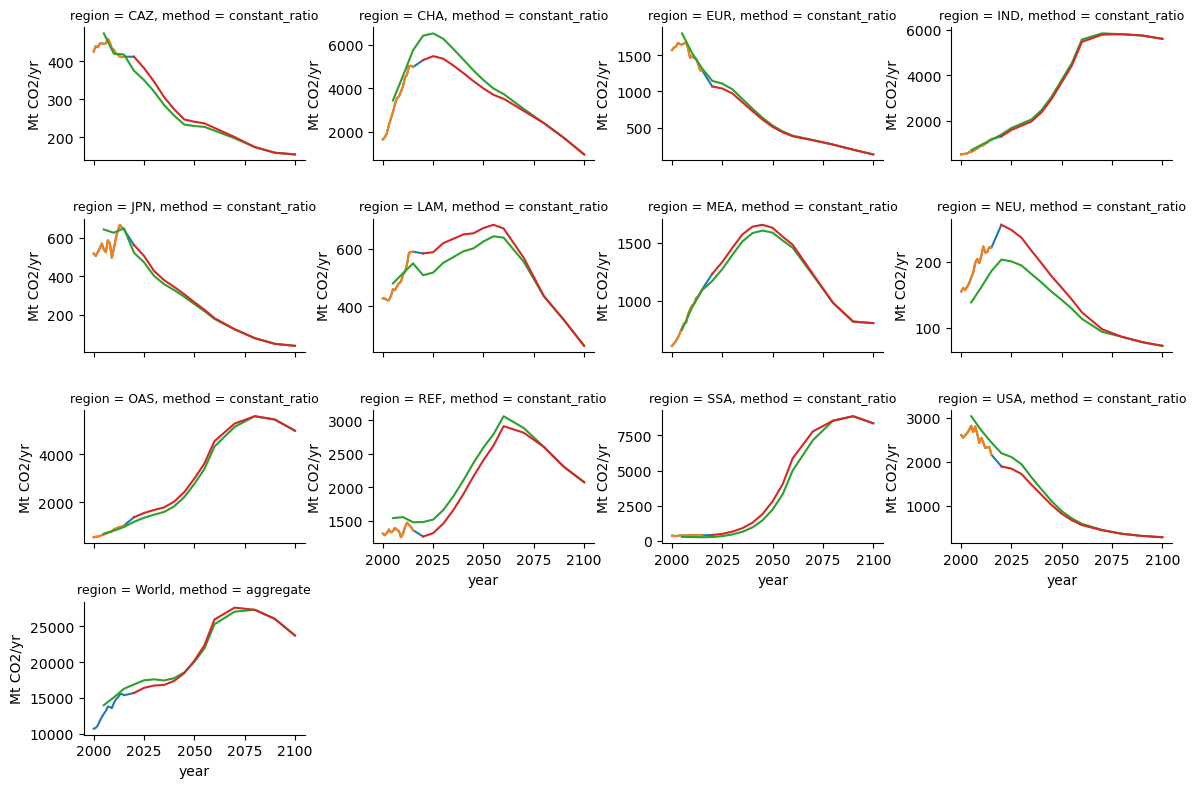

In [17]:
g = plot_harm(
    isin(sector="Energy Sector", gas="CO2"),
    scenario="RESCUE-Tier1-Extension-2023-07-27-Baseline",
)

# Make Comparison Notebooks

In [18]:
def what_changed(next, prev):
    length = len(next)
    if prev is None:
        return range(length)
    for i in range(len(next)):
        if prev[i] != next[i]:
            return range(i, length)

In [19]:
def make_doc(order, scenario=None, compact=False):
    if scenario is None:
        ((m, s),) = harm.pix.unique(["model", "scenario"])
    else:
        m = harm.pix.unique("model").item()
        s = scenario

    index = harm.index.pix.unique(order).sort_values()
    doc = document(title=f"Harmonization results: {m} - {s}")

    main = doc.add(div())
    prev_idx = None
    for idx in tqdm(index):
        main.add([HEADING_TAGS[i](idx[i]) for i in what_changed(idx, prev_idx)])

        ax = plot_harm(isin(**dict(zip(index.names, idx)), ignore_missing_levels=True), scenario=scenario)
        main.add(embed_image(ax, close=True))

        prev_idx = idx

    add_sticky_toc(doc, max_level=2, compact=compact) 
    return doc

In [20]:
def shorten(scenario):
    return scenario.removeprefix("RESCUE-Tier1-Extension-2023-07-27-")

In [26]:
files = []

In [30]:
for scenario in harm.pix.unique("scenario"):
    fn = out_path / f"harmonization-{version}-single-{shorten(scenario)}.html"
    with open(fn, "w", encoding="utf-8") as f:
        print(
            make_doc(
                order=["gas", "sector", "region"], scenario=scenario, compact=False
            ),
            file=f,
        )
    files.append(fn)

100%|██████████| 1333/1333 [12:02<00:00,  1.85it/s] 


In [29]:
def make_scenario_facets(scenario):
    fn = out_path / f"harmonization-{version}-facet-{shorten(scenario)}.html"
    with open(fn, "w", encoding="utf-8") as f:
        print(make_doc(order=["gas", "sector"], scenario=scenario), file=f)
    return fn
files.extend(
    Parallel(n_jobs=10, verbose=10)(
        delayed(make_scenario_facets)(scenario)
        for scenario in harm.pix.unique("scenario")
    )
)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
100%|██████████| 133/133 [13:15<00:00,  5.98s/it]
[Parallel(n_jobs=10)]: Done   2 out of  19 | elapsed: 13.4min remaining: 113.6min
100%|██████████| 133/133 [13:18<00:00,  6.00s/it]
[Parallel(n_jobs=10)]: Done   4 out of  19 | elapsed: 13.4min remaining: 50.3min
100%|██████████| 133/133 [13:20<00:00,  6.02s/it]
[Parallel(n_jobs=10)]: Done   6 out of  19 | elapsed: 13.5min remaining: 29.1min
100%|██████████| 133/133 [13:22<00:00,  6.03s/it]
[Parallel(n_jobs=10)]: Done   8 out of  19 | elapsed: 13.5min remaining: 18.5min
100%|██████████| 133/133 [13:23<00:00,  6.04s/it]
[Parallel(n_jobs=10)]: Done  10 out of  19 | elapsed: 13.5min remaining: 12.2min
 29%|██▉       | 39/133 [05:20<16:09, 10.31s/it]

In [ ]:
files = Path(".").glob(f"harmonization-{version}-*")

In [ ]:
for fn in files:
    run(["aws", "s3", "cp", fn, "s3://rescue-task1.3/harmonization/"])